In [29]:
!pip install torch-summary
!pip install torchmetrics

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea # You imported seaborn as 'sea'
import os
import cv2 as op
import torch
from tqdm.notebook import tqdm
from torchsummary import summary
import torchmetrics

# sea.set_theme() # This is the correct way
sea.set_theme(style="darkgrid") # You can also specify a style

np.__version__

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
PATH = '/content/drive/MyDrive/dataset'
label2id = {}
print(os.listdir(PATH))
for i, label in enumerate(os.listdir(PATH)):
    label2id[label] = i
print(label2id)

id2label = {key : value for (value, key) in label2id.items()}
print(id2label)

filenames, outcome = [], []
for label in tqdm(os.listdir(PATH)):
    for img in os.listdir(os.path.join(PATH, label)):
        filenames.append(os.path.join(PATH, label, img))
        outcome.append(label2id[label])

print(filenames)
print(outcome)
df = pd.DataFrame({
    "filename" : filenames,
    "outcome" : outcome
})

df = df.sample(frac = 1)
df

['glaucoma', 'cataract', 'diabetic_retinopathy', 'normal']
{'glaucoma': 0, 'cataract': 1, 'diabetic_retinopathy': 2, 'normal': 3}
{0: 'glaucoma', 1: 'cataract', 2: 'diabetic_retinopathy', 3: 'normal'}


  0%|          | 0/4 [00:00<?, ?it/s]

['/content/drive/MyDrive/dataset/glaucoma/_97_3920460.jpg', '/content/drive/MyDrive/dataset/glaucoma/_90_7427306.jpg', '/content/drive/MyDrive/dataset/glaucoma/_91_8145296.jpg', '/content/drive/MyDrive/dataset/glaucoma/_98_763638.jpg', '/content/drive/MyDrive/dataset/glaucoma/_92_2709771.jpg', '/content/drive/MyDrive/dataset/glaucoma/_67_4921455.jpg', '/content/drive/MyDrive/dataset/glaucoma/_98_4213035.jpg', '/content/drive/MyDrive/dataset/glaucoma/_95_6242980.jpg', '/content/drive/MyDrive/dataset/glaucoma/_99_5348098.jpg', '/content/drive/MyDrive/dataset/glaucoma/_79_7226209.jpg', '/content/drive/MyDrive/dataset/glaucoma/_94_8906983.jpg', '/content/drive/MyDrive/dataset/glaucoma/_90_4845886.jpg', '/content/drive/MyDrive/dataset/glaucoma/_99_9780664.jpg', '/content/drive/MyDrive/dataset/glaucoma/_76_8587652.jpg', '/content/drive/MyDrive/dataset/glaucoma/_79_266127.jpg', '/content/drive/MyDrive/dataset/glaucoma/_97_139770.jpg', '/content/drive/MyDrive/dataset/glaucoma/_91_4030510.jpg',

,filename,outcome
288,/content/drive/MyDrive/dataset/glaucoma/_289_9...,0
2710,/content/drive/MyDrive/dataset/diabetic_retino...,2
673,/content/drive/MyDrive/dataset/glaucoma/1434_l...,0
3176,/content/drive/MyDrive/dataset/normal/3445_lef...,3
27,/content/drive/MyDrive/dataset/glaucoma/_374_8...,0
...,...,...
227,/content/drive/MyDrive/dataset/glaucoma/_396_2...,0
3183,/content/drive/MyDrive/dataset/normal/3427_lef...,3
3667,/content/drive/MyDrive/dataset/normal/2432_lef...,3
3768,/content/drive/MyDrive/dataset/normal/2486_lef...,3


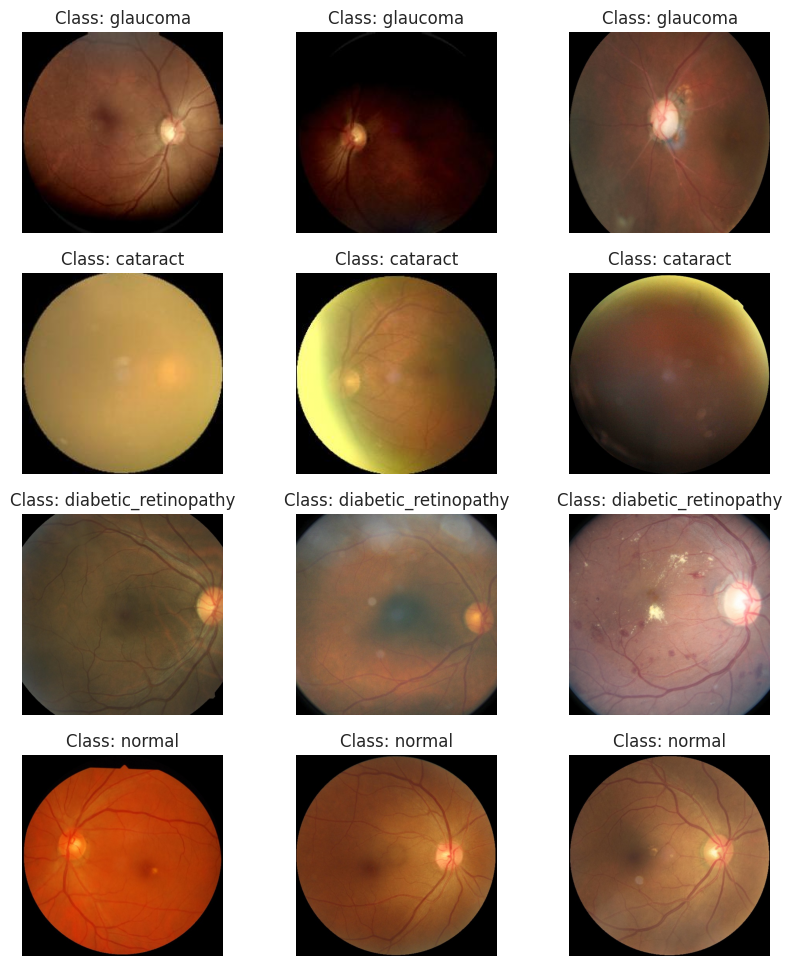

In [33]:
def load_image(path):
    img = plt.imread(path)
    img = (img - img.min())/img.max()
    return img

counter = 0

plt.figure(figsize = (10, 12))

for i in range(4):
    for path in df[df['outcome'] == i].sample(n = 3)['filename']:
        plt.subplot(4, 3, counter + 1)
        img = load_image(path)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Class:' + " " + id2label[i])
        counter += 1

plt.show()

<Axes: xlabel='outcome', ylabel='count'>

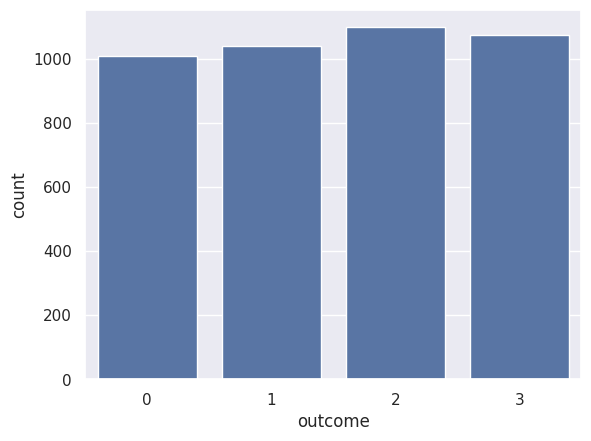

In [34]:
sea.countplot(x = 'outcome', data = df)

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define the root path of the dataset
root_path = '/content/drive/MyDrive/dataset'

# Define the transforms
transform = transforms.Compose([
    transforms.Resize((256, 256), antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create the dataset
dataset = datasets.ImageFolder(root=root_path, transform=transform)
print(dataset)


Dataset ImageFolder
    Number of datapoints: 4217
    Root location: /content/drive/MyDrive/dataset
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [36]:
# Split the dataset into training and validation sets
train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
print(train_dataset)
print(val_dataset)

# Create the DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
print(train_loader)
print(val_loader)

# Load a pretrained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the fully connected layer for 4 classes (assuming 4 classes)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 97.5MB/s]


In [37]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, device):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=0.001)
        # Add the scheduler inside the __init__ method
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.1) # <<< ADD THIS LINE
        self.history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    def training_step(self, X, y):
        self.model.train()
        self.optimizer.zero_grad()
        outputs = self.model(X)
        loss = self.criterion(outputs, y)
        loss.backward()
        self.optimizer.step()
        _, preds = torch.max(outputs, 1)
        acc = (preds == y).float().mean()
        return loss.item(), acc.item()

    def val_step(self, X, y):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X)
            loss = self.criterion(outputs, y)
            _, preds = torch.max(outputs, 1)
            acc = (preds == y).float().mean()
        return loss.item(), acc.item()

    def step_fxn(self, loader, step):
        total_loss, total_acc = 0, 0
        for X, y in tqdm(loader):
            X, y = X.to(self.device), y.to(self.device)
            l, a = step(X, y)
            total_loss += l
            total_acc += a
        return total_loss / len(loader), total_acc / len(loader)

    def train(self, epochs):
        for epoch in tqdm(range(epochs)):
            train_loss, train_acc = self.step_fxn(self.train_loader, self.training_step)
            val_loss, val_acc = self.step_fxn(self.val_loader, self.val_step)
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_acc'].append(val_acc)
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

            # Add the scheduler step at the end of the epoch loop
            self.scheduler.step() # <<< ADD THIS LINE
# Initialize and train the model
trainer = Trainer(model, train_loader, val_loader, device)
trainer.train(epochs=2)
trainer

100%|██████████| 56/56 [36:45<00:00, 39.39s/it]

 50%|█████     | 1/2 [40:18<40:18, 2418.43s/it]

Epoch 1/2, Train Loss: 0.4117, Train Acc: 0.8454, Val Loss: 0.3530, Val Acc: 0.8631



100%|██████████| 56/56 [25:29<00:00, 27.31s/it]

100%|██████████| 2/2 [1:07:21<00:00, 2020.93s/it]

Epoch 2/2, Train Loss: 0.2342, Train Acc: 0.9124, Val Loss: 0.2910, Val Acc: 0.8953


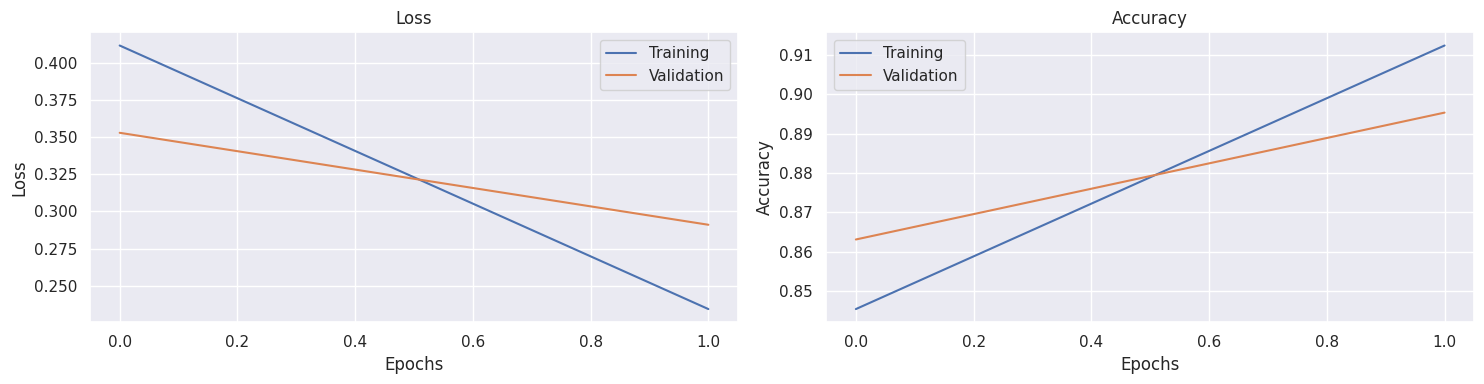

In [38]:
import matplotlib.pyplot as plt

# Set the size of the figure
plt.figure(figsize=(15, 4))

# Plot for Loss
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(trainer.history['train_loss'], label='Training')
plt.plot(trainer.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for Accuracy
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(trainer.history['train_acc'], label='Training')
plt.plot(trainer.history['val_acc'], label='Validation')  # Corrected label to 'Validation'
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()  # Adjust the layout to prevent overlapping
plt.show()

In [39]:
preds, true = [], []

with torch.no_grad():
    for x, y in tqdm(val_loader):
        pred = torch.argmax(trainer.model(x.to(device)), axis = 1).detach().cpu().numpy()
        preds.extend(pred)
        true.extend(y)


100%|██████████| 10/10 [01:32<00:00,  9.27s/it]


In [40]:
# Assuming 'preds' and 'true' are your predicted and true labels respectively

# Iterate over both lists and print the actual and predicted values
for actual, predicted in zip(true, preds):
    print(f'Actual: {actual}, Predicted: {predicted}')


Actual: 2, Predicted: 2
Actual: 1, Predicted: 1
Actual: 2, Predicted: 3
Actual: 2, Predicted: 2
Actual: 2, Predicted: 3
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 2, Predicted: 2
Actual: 2, Predicted: 2
Actual: 1, Predicted: 1
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 2, Predicted: 2
Actual: 3, Predicted: 3
Actual: 1, Predicted: 1
Actual: 2, Predicted: 3
Actual: 0, Predicted: 3
Actual: 2, Predicted: 2
Actual: 1, Predicted: 1
Actual: 3, Predicted: 3
Actual: 3, Predicted: 3
Actual: 1, Predicted: 1
Actual: 1, Predicted: 1
Actual: 1, Predicted: 1
Actual: 1, Predicted: 1
Actual: 3, Predicted: 3
Actual: 2, Predicted: 2
Actual: 2, Predicted: 2
Actual: 2, Predicted: 3
Actual: 0, Predicted: 0
Actual: 3, Predicted: 3
Actual: 0, Predicted: 0
Actual: 2, Predicted: 2
Actual: 1, Predicted: 1
Actual: 1, Predicted: 1
Actual: 3, Predicted: 3
Actual: 2, Predicted: 2
Actual: 3, Predicted: 3
Actual: 3, Predicted: 3
Actual: 2, Predicted: 2
Actual: 1, Predicted: 1
Actual: 3, Predi

Text(0.5, 1.0, 'Confusion Matrix')

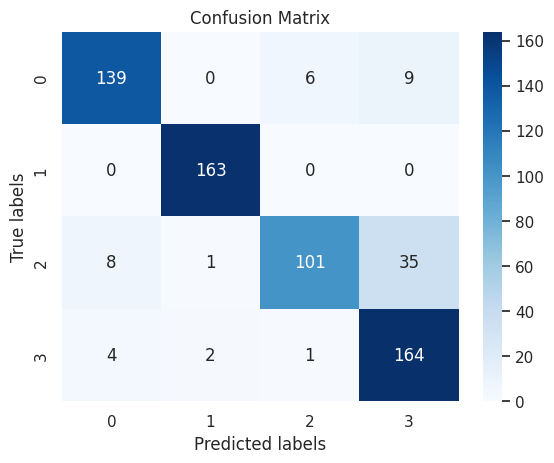

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sea
cm = confusion_matrix(true, preds)
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

In [42]:
from sklearn.metrics import accuracy_score

# Assume true and preds are your true labels and predictions

# Calculate and print the accuracy
accuracy = accuracy_score(true, preds)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8957


<Axes: >

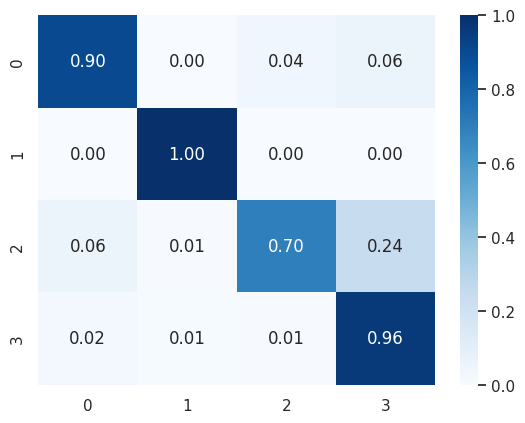

In [43]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sea.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', cbar=True)


<Axes: >

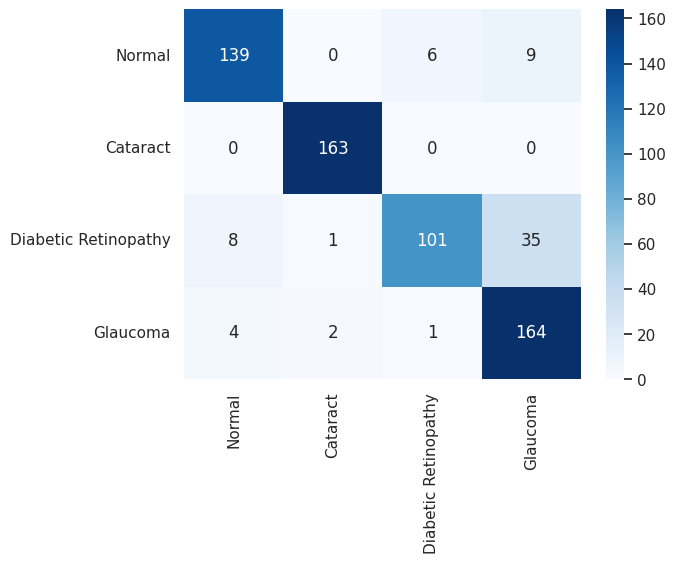

In [44]:
class_names = ['Normal', 'Cataract', 'Diabetic Retinopathy','Glaucoma']  # Replace with your actual class names
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=class_names, yticklabels=class_names)


In [45]:
# Define separate transforms for training and validation
train_transform = transforms.Compose([
    transforms.Resize((256, 256), antialias=True),
    transforms.RandomHorizontalFlip(), # Flips the image horizontally
    transforms.RandomRotation(10),      # Rotates the image by up to 10 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256), antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Important: Apply the correct transform to the correct dataset split
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

In [49]:
from sklearn.metrics import classification_report

print(classification_report(true, preds, target_names=class_names))

                      precision    recall  f1-score   support

              Normal       0.92      0.90      0.91       154
            Cataract       0.98      1.00      0.99       163
Diabetic Retinopathy       0.94      0.70      0.80       145
            Glaucoma       0.79      0.96      0.87       171

            accuracy                           0.90       633
           macro avg       0.91      0.89      0.89       633
        weighted avg       0.90      0.90      0.89       633



In [50]:
# After training
torch.save(trainer.model.state_dict(), 'retinopathy_resnet18_model.pth')
print("Model saved successfully!")

Model saved successfully!


In [53]:
from PIL import Image

def predict_image(image_path, model, transform, device, id2label):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        pred_index = torch.argmax(output, axis=1).item()
        predicted_class = id2label[pred_index]

    return predicted_class

# Example usage:
new_image_path = '/content/drive/MyDrive/dataset/cataract/1083_left.jpg'
prediction = predict_image(new_image_path, trainer.model, val_transform, device, id2label)
print(f"The predicted class is: {prediction}")

The predicted class is: glaucoma


In [54]:
# Make sure 'trainer' is your trained model trainer object
torch.save(trainer.model.state_dict(), 'retinopathy_model.pth')